In [19]:
import pandas as pd
from database.market import Market
from datetime import datetime,timedelta
from parameters.parameters import Parameters
from backtester.backtester_lite import BacktesterLite
from processor.processor import Processor as p
from tqdm import tqdm
import matplotlib.pyplot as plt

In [20]:
market = Market()

In [21]:
market.connect()
sp500 = market.retrieve("sp500").rename(columns={"Symbol":"ticker"})
market.disconnect()

In [22]:
start_date = datetime(2001,1,1)
end_date = datetime(2020,1,1)
lookbacks = [1,5,20,60]
holding_periods = [1,5,10,15,20]
floors = [-10,0,0.05,0.1]
ceilings = [0.1,0.5,1,10]
volatilities = []
# positions = 20
# tickers = sp500["ticker"]
# asset = "stocks"
positions = 1
tickers = ["BTC"]
asset = "crypto"

In [23]:
parameters = Parameters.parameters_lite(lookbacks,holding_periods,ceilings,floors)

In [24]:
len(parameters)

1280

In [25]:
simulation = []
market.connect()
for ticker in tqdm(tickers):
    try:
        ticker_data = market.retrieve_ticker_prices(asset,ticker)
        ticker_data = p.column_date_processing(ticker_data)
        ticker_data.sort_values("date",inplace=True)
        ticker_data["week"] = [x.week for x in ticker_data["date"]]
        ticker_data["day"] = [x.weekday() for x in ticker_data["date"]]
        ticker_data["prev_close"] = ticker_data["adjclose"].shift(1)
        for lookback in lookbacks:
            ticker_data[f"window_{lookback}"] = ticker_data["prev_close"].shift(lookback)
            ticker_data[f"rolling_{lookback}"] = ticker_data["prev_close"].rolling(lookback).mean()
#             ticker_data[f"rolling_stdev_{lookback}"] = ticker_data["prev_close"].rolling(lookback).std()
#             ticker_data[f"rolling_pct_stdev_{lookback}"] = ticker_data[f"rolling_stdev_{lookback}"] / ticker_data[f"rolling_{lookback}"]
        for holding_period in holding_periods:
            ticker_data[f"return_{holding_period}"] = (ticker_data["adjclose"].shift(-holding_period) - ticker_data["adjclose"]) / ticker_data["adjclose"]
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))
market.disconnect()
final = pd.concat(simulation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


In [26]:
final = pd.concat(simulation)

In [27]:
final

,date,open,high,low,adjclose,volume,volumenotional,tradesdone,ticker,year,...,rolling_5,window_20,rolling_20,window_60,rolling_60,return_1,return_5,return_10,return_15,return_20
4300,2011-08-22,11.700000,11.700000,11.700000,11.700000,0.090000,1.053000e+00,0.0,BTC,2011,...,11.700000,11.700000,11.700000,10.900000,11.456833,0.000000,0.000000,0.000000,0.000000,0.000000
8598,2011-08-22,11.700000,11.700000,11.700000,11.700000,0.090000,1.053000e+00,0.0,BTC,2011,...,11.700000,11.700000,11.700000,10.900000,11.470167,0.000000,0.000000,0.000000,0.000000,0.000000
77813,2011-08-22,11.700000,11.700000,11.700000,11.700000,0.090000,1.053000e+00,0.0,BTC,2011,...,11.700000,11.700000,11.700000,10.900000,11.483500,0.000000,0.000000,0.000000,0.000000,0.000000
43105,2011-08-22,11.700000,11.700000,11.700000,11.700000,0.090000,1.053000e+00,0.0,BTC,2011,...,11.700000,11.700000,11.700000,10.900000,11.496833,0.000000,0.000000,0.000000,0.000000,0.000000
34450,2011-08-22,11.700000,11.700000,11.700000,11.700000,0.090000,1.053000e+00,0.0,BTC,2011,...,11.700000,11.700000,11.700000,10.900000,11.510167,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69122,2023-08-05,29082.894158,29118.065846,28953.145428,29051.174830,3169.025186,9.206390e+07,157724.0,BTC,2023,...,29051.174830,29633.287964,29110.285444,29358.374157,29275.862082,-0.000135,-0.000385,0.004550,0.024805,0.024509
73464,2023-08-06,29051.063462,29167.647143,28961.741805,29047.264696,3121.588970,9.067362e+07,145192.0,BTC,2023,...,29051.174830,29088.545441,29108.416913,29358.374157,29270.742093,0.000000,0.000000,0.004545,0.024882,0.034951
64783,2023-08-06,29051.063462,29167.647143,28961.741805,29047.264696,3121.588970,9.067362e+07,145192.0,BTC,2023,...,29050.392804,29177.583336,29101.900981,29358.374157,29265.556935,0.000000,-0.000529,0.004685,0.007757,0.016674
77805,2023-08-06,29051.063462,29167.647143,28961.741805,29047.264696,3121.588970,9.067362e+07,145192.0,BTC,2023,...,29049.610777,29177.583336,29095.385049,29358.374157,29260.371778,0.000000,0.004685,0.024882,0.017879,0.013090


In [28]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = BacktesterLite.backtest(positions,final.copy(),iteration,parameter,False)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:56<00:00, 22.72it/s]


In [29]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [30]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

  2%|██▉                                                                                                                                                                 | 23/1280 [00:00<00:31, 40.29it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


  3%|█████▎                                                                                                                                                              | 41/1280 [00:01<00:25, 47.84it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


  5%|███████▊                                                                                                                                                            | 61/1280 [00:01<00:24, 50.65it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


  6%|██████████▍                                                                                                                                                         | 81/1280 [00:01<00:23, 51.54it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


  8%|████████████▌                                                                                                                                                       | 98/1280 [00:02<00:21, 55.97it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 14%|███████████████████████                                                                                                                                            | 181/1280 [00:03<00:22, 49.61it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 20%|█████████████████████████████████                                                                                                                                  | 260/1280 [00:05<00:16, 62.06it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 27%|███████████████████████████████████████████▍                                                                                                                       | 341/1280 [00:07<00:19, 48.67it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 28%|█████████████████████████████████████████████▉                                                                                                                     | 361/1280 [00:07<00:18, 50.04it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 30%|████████████████████████████████████████████████▌                                                                                                                  | 381/1280 [00:08<00:17, 50.68it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 31%|███████████████████████████████████████████████████                                                                                                                | 401/1280 [00:08<00:17, 51.23it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 33%|█████████████████████████████████████████████████████▉                                                                                                             | 424/1280 [00:09<00:17, 48.94it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 39%|███████████████████████████████████████████████████████████████▊                                                                                                   | 501/1280 [00:10<00:15, 49.84it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                         | 581/1280 [00:12<00:13, 51.03it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                               | 658/1280 [00:13<00:11, 53.12it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 57%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 731/1280 [00:15<00:13, 41.04it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 821/1280 [00:17<00:09, 48.86it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 901/1280 [00:19<00:07, 50.22it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 981/1280 [00:20<00:06, 48.04it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1058/1280 [00:22<00:04, 51.00it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1141/1280 [00:24<00:02, 47.65it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1221/1280 [00:26<00:01, 50.23it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:27<00:00, 46.72it/s]


In [31]:
performance = pd.DataFrame(report)

In [32]:
performance.sort_values("pv",ascending=False).head(20)

position,pv,iteration,strategy,value,lookback,holding_period,floor,ceiling
3016,1274.482833,425,rolling,False,5,1,0.0,0.5
3016,1274.482833,405,rolling,False,5,1,0.0,0.1
3016,1274.482833,465,rolling,False,5,1,0.0,10.0
3016,1274.482833,445,rolling,False,5,1,0.0,1.0
3021,1177.373761,725,window,True,5,1,0.0,0.1
3021,1177.373761,645,window,True,1,1,0.0,0.1
3021,1177.373761,640,window,True,1,1,-10.0,0.1
3021,1177.373761,720,window,True,5,1,-10.0,0.1
3021,689.287389,660,window,True,1,1,-10.0,0.5
3021,689.287389,745,window,True,5,1,0.0,0.5


In [33]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [34]:
cumulative

position,date,0.0,pv
0,2011-08-22,1.000000,1.000000
1,2011-08-23,0.897436,0.897436
2,2011-08-25,0.952381,0.854701
3,2011-08-26,0.800000,0.683761
4,2011-08-31,1.027500,0.702564
...,...,...,...
3012,2019-12-28,1.010096,1352.382762
3013,2019-12-29,0.980018,1325.358839
3014,2019-12-30,0.992840,1315.869118
3015,2019-12-31,1.000968,1317.142949


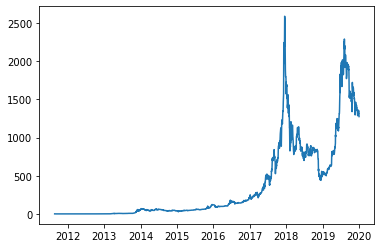

In [35]:
plt.plot(cumulative["date"],cumulative["pv"])

In [36]:
parameter

{'strategy': 'rolling',
 'value': False,
 'lookback': 5,
 'holding_period': 1,
 'floor': 0,
 'ceiling': 0.5}